In [1]:
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from src.run import run
from src.dataloader import MyDataset
from src.evaluate import eval, loss_plot, result_plot
from src.model.vanilla import Vanilla3d

model_list = {
    'vanilla': Vanilla3d
}

optimizer_list = {
    'adam': optim.Adam
}

loss_list = {
    'mse': nn.MSELoss,
    'bce': nn.BCELoss
}

scheduler_list = {
    'cosine': optim.lr_scheduler.CosineAnnealingLR
}

In [2]:
class Args:
    
    def __init__(self, task_type='binary', batch_size=8):
        
        self.task_type = task_type
        self.batch_size = batch_size

In [3]:
args = Args()

In [4]:
# 00. Load Data
train_dset = MyDataset(args.task_type)
test_dset = MyDataset(args.task_type, test=True)

train_loader = DataLoader(train_dset, batch_size=args.batch_size)
test_loader = DataLoader(test_dset, batch_size=args.batch_size)

In [5]:
for i, (x, y) in enumerate(train_loader):
    if i < 1:
        x = x
        
    else: break

In [6]:
import matplotlib.pyplot as plt
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [47]:
epi_img_data = x[0]

In [48]:
epi_img_data = epi_img_data.squeeze()

In [49]:
epi_img_data.shape

torch.Size([256, 256, 256])

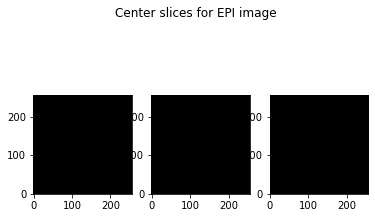

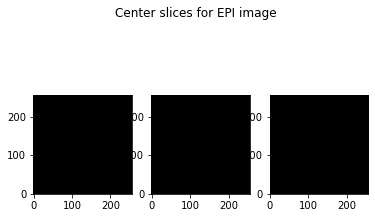

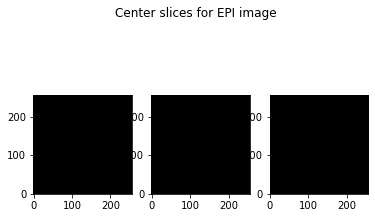

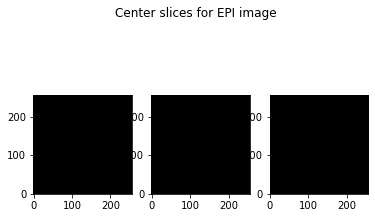

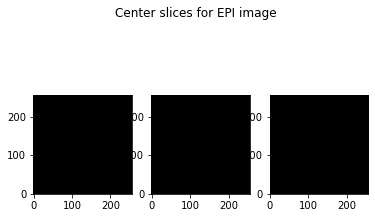

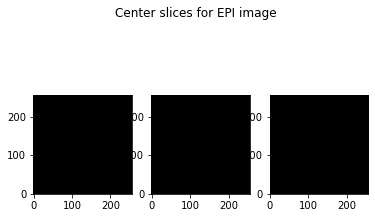

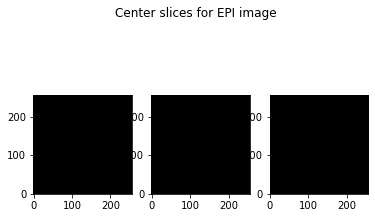

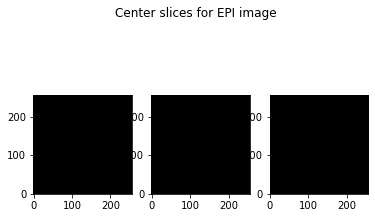

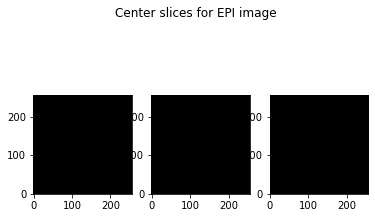

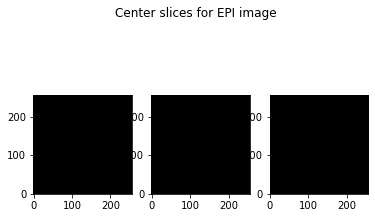

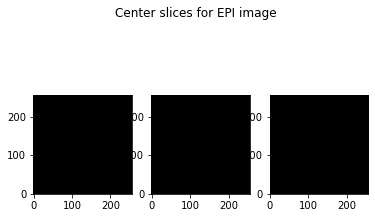

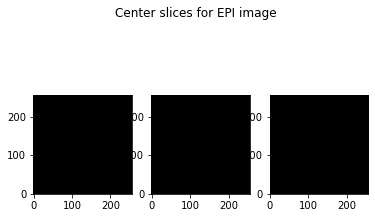

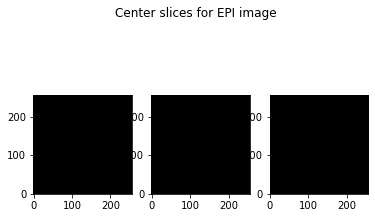

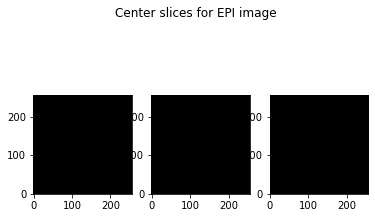

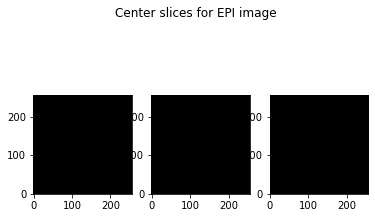

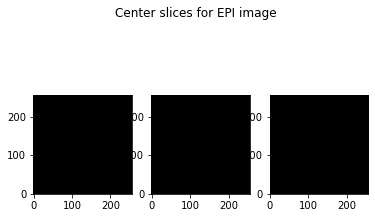

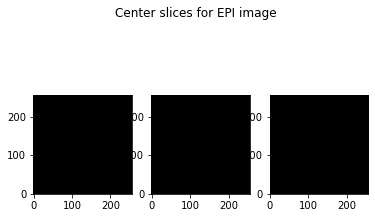

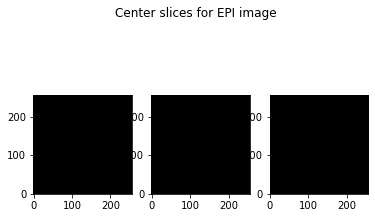

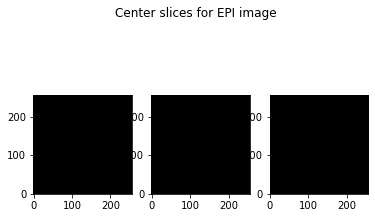

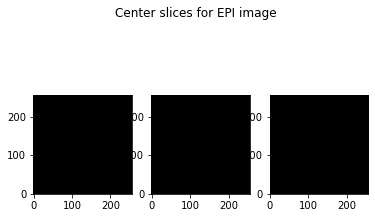

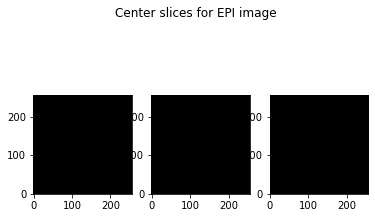

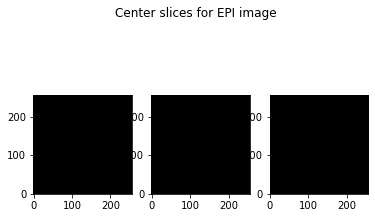

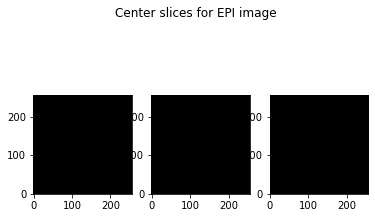

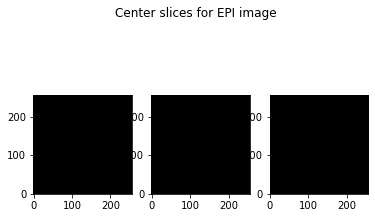

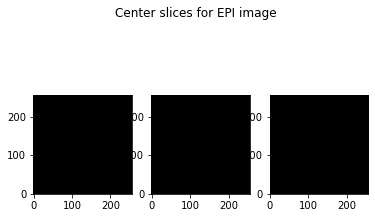

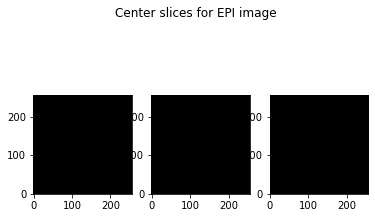

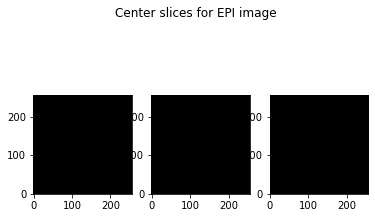

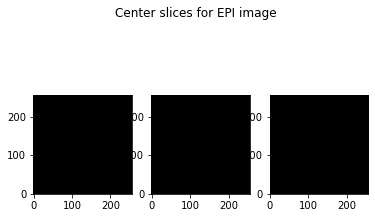

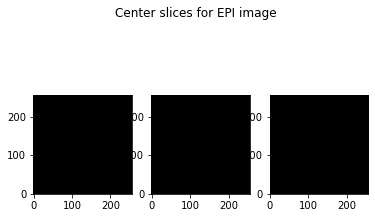

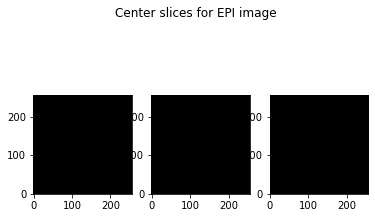

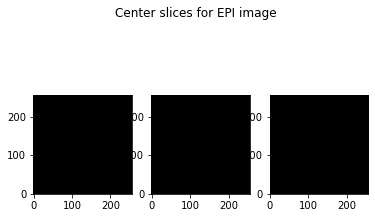

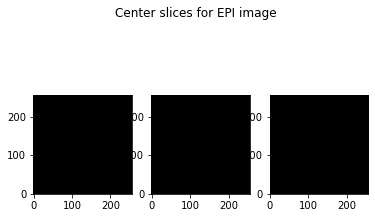

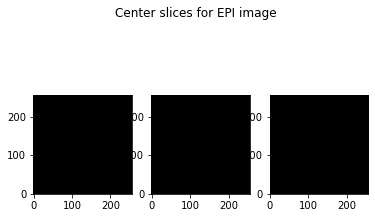

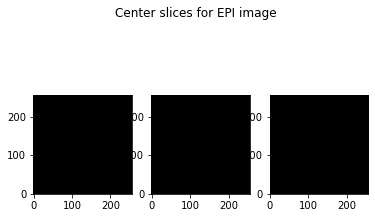

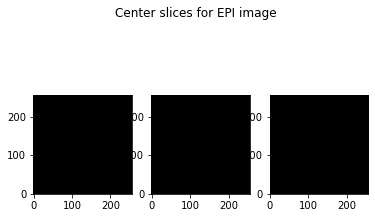

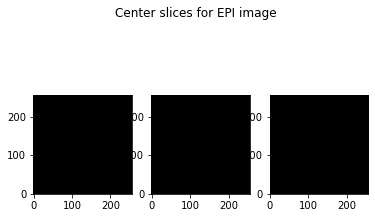

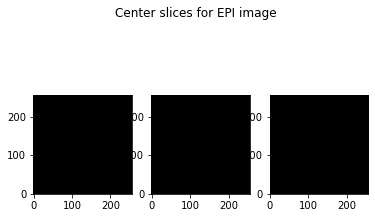

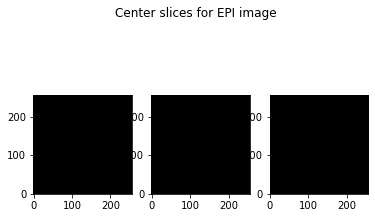

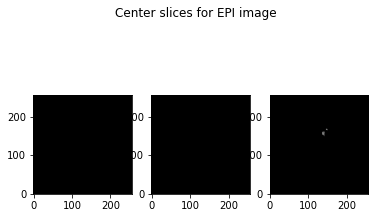

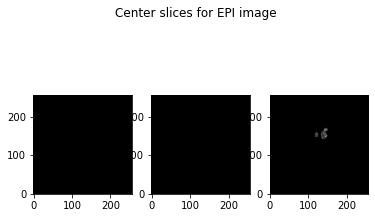

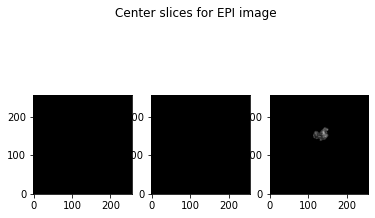

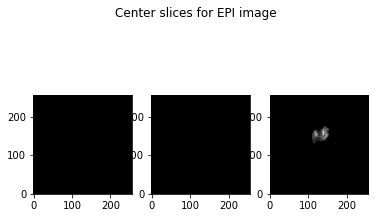

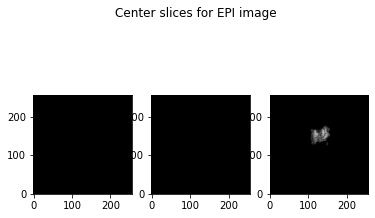

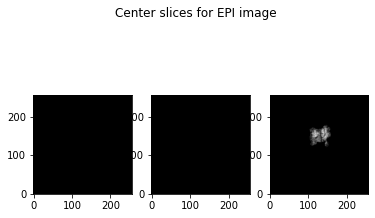

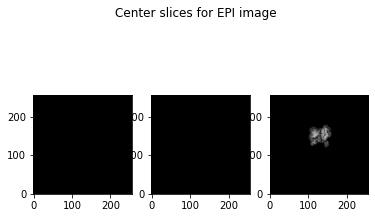

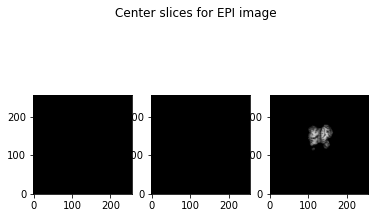

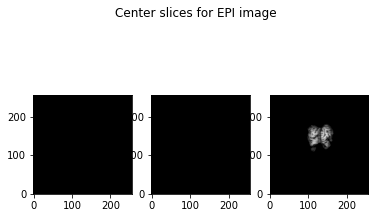

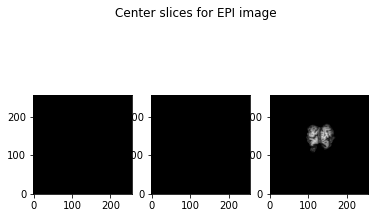

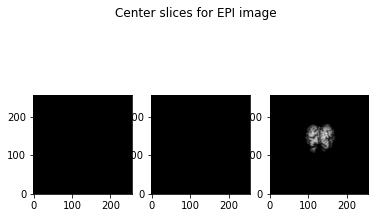

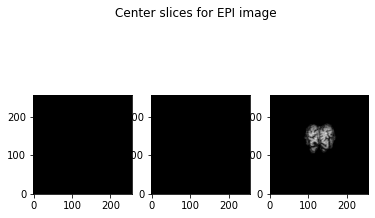

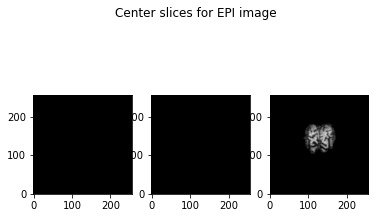

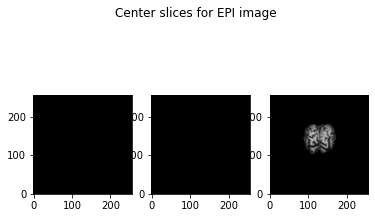

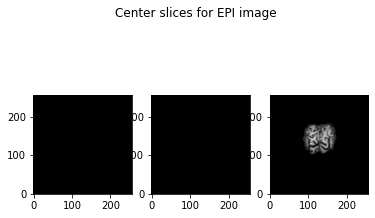

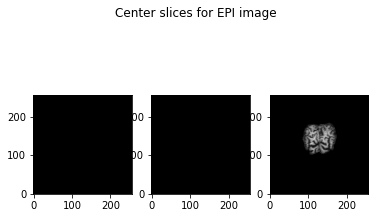

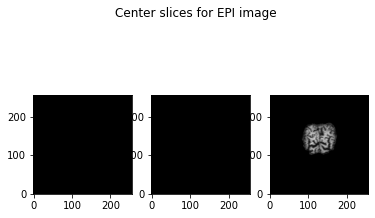

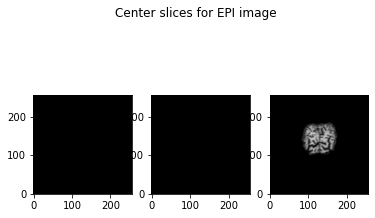

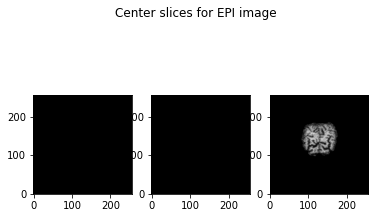

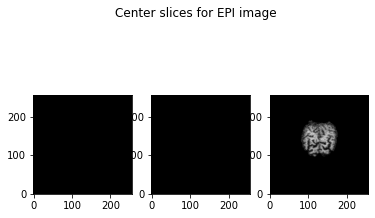

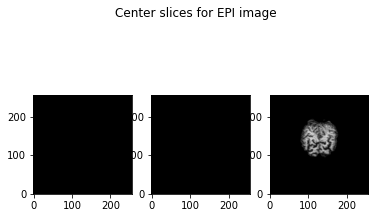

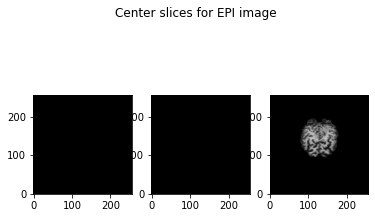

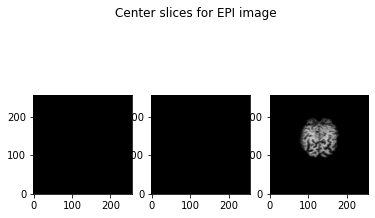

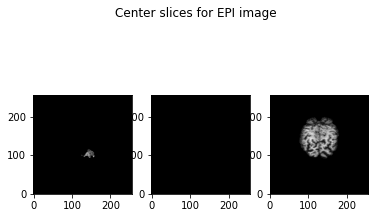

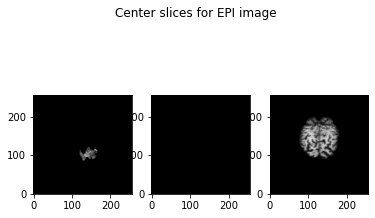

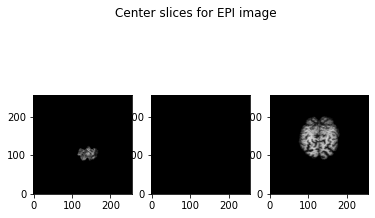

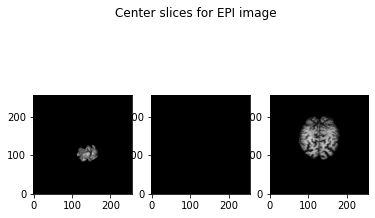

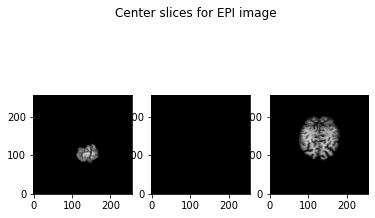

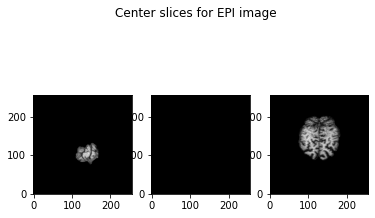

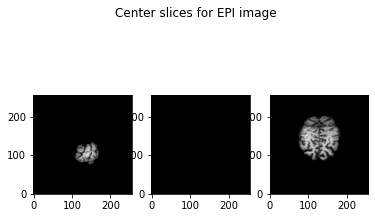

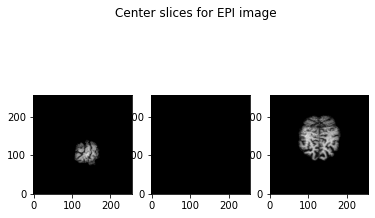

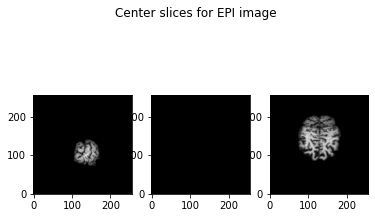

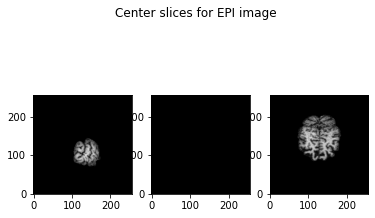

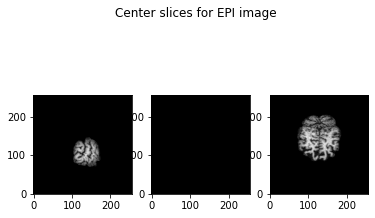

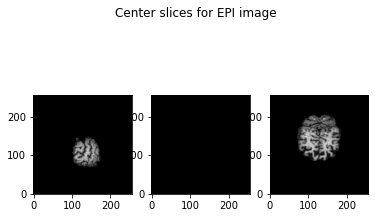

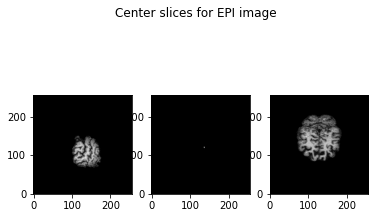

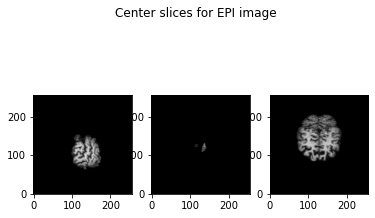

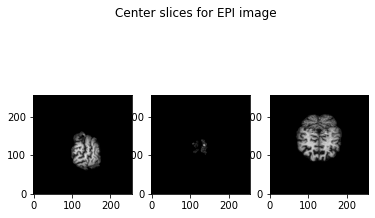

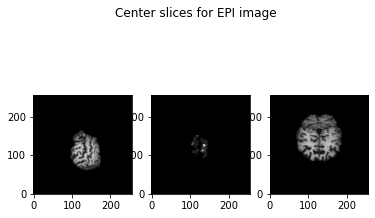

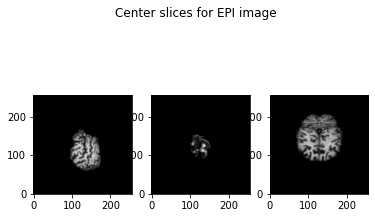

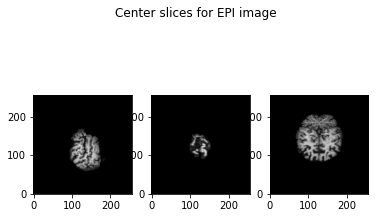

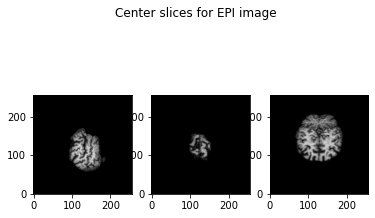

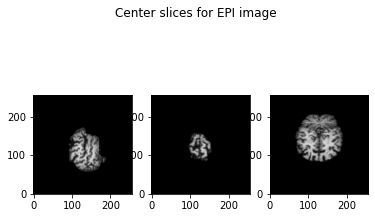

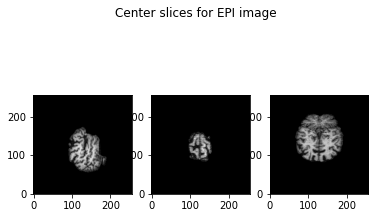

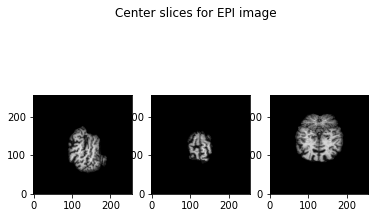

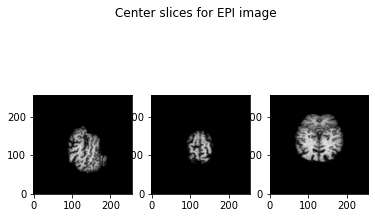

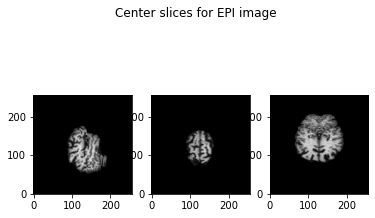

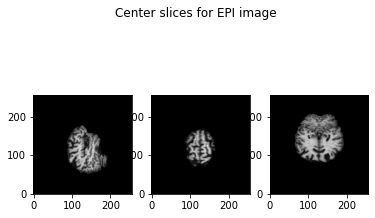

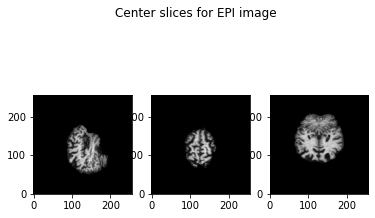

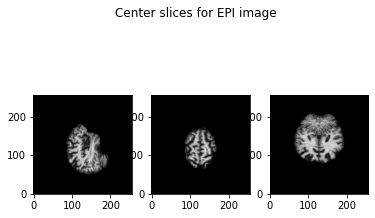

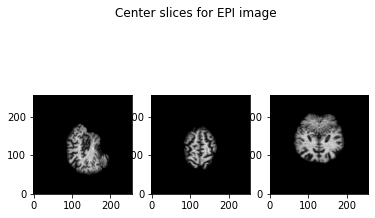

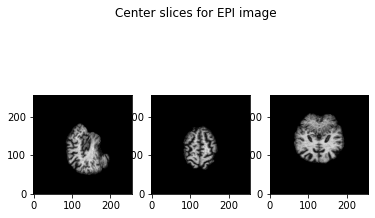

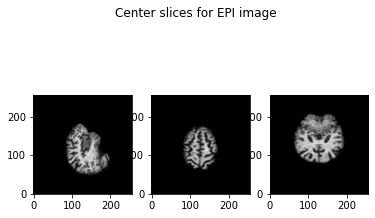

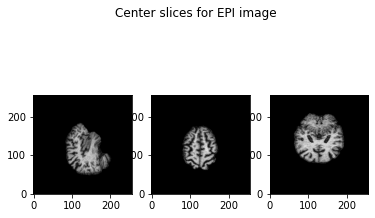

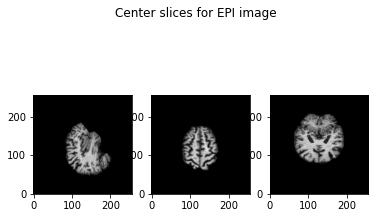

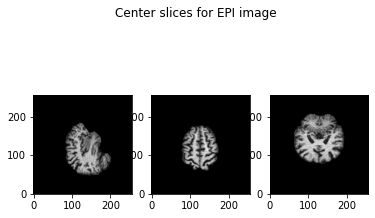

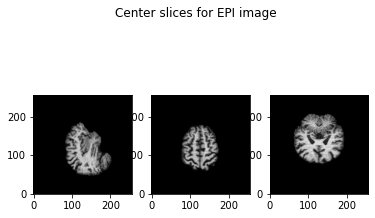

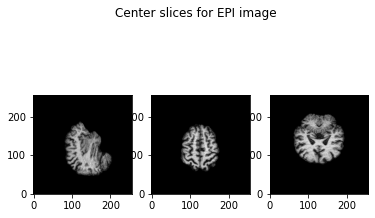

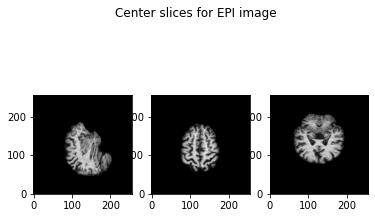

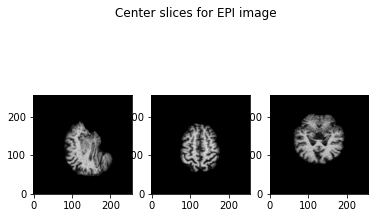

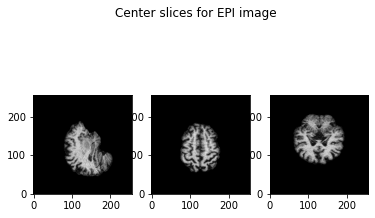

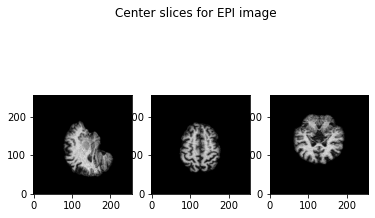

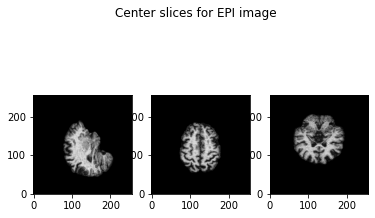

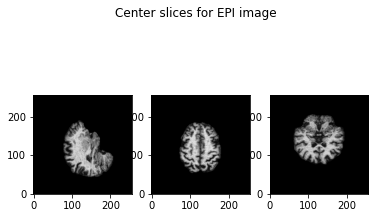

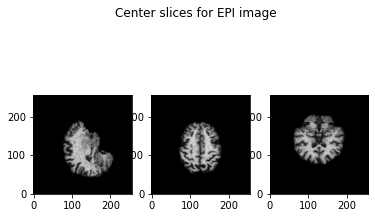

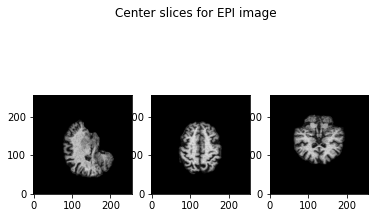

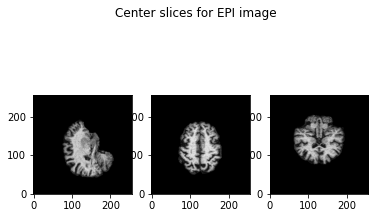

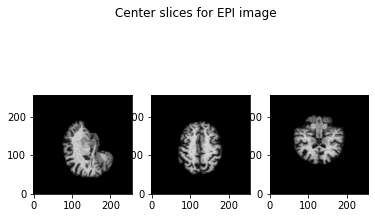

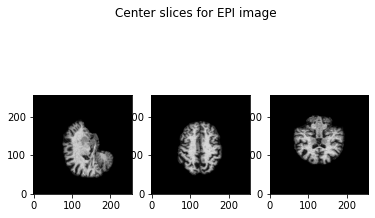

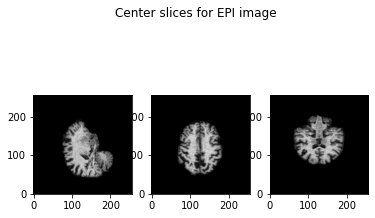

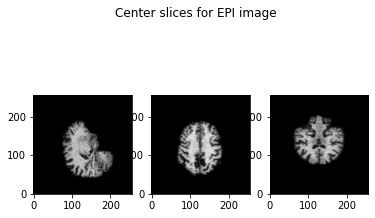

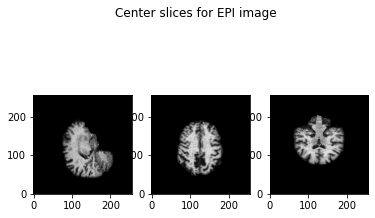

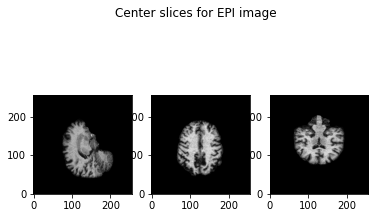

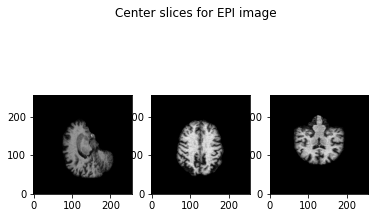

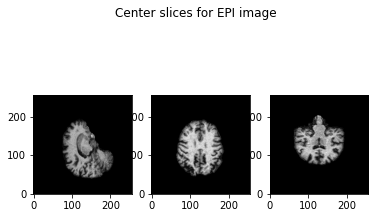

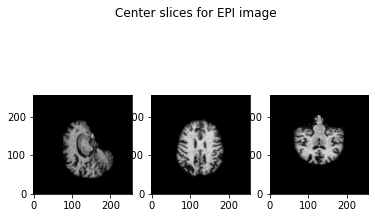

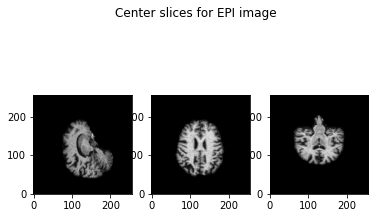

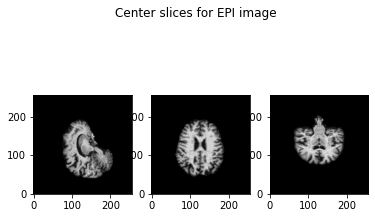

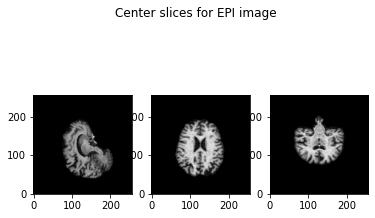

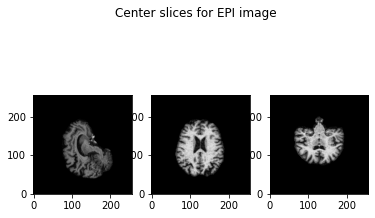

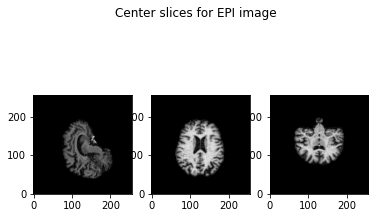

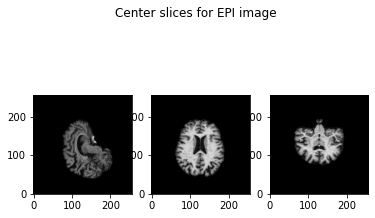

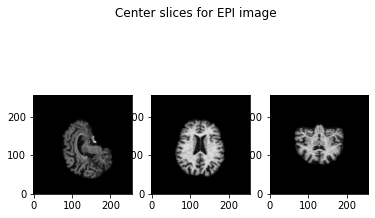

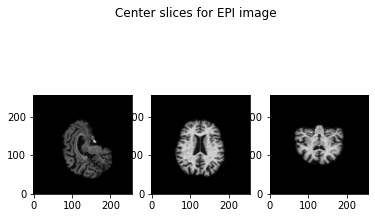

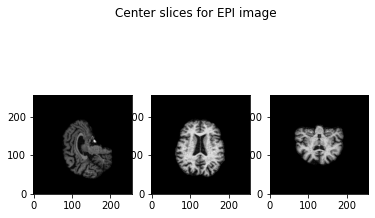

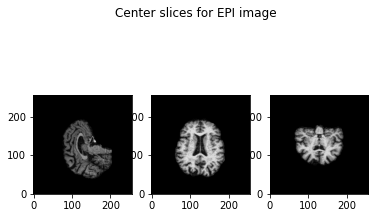

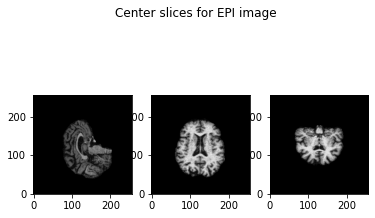

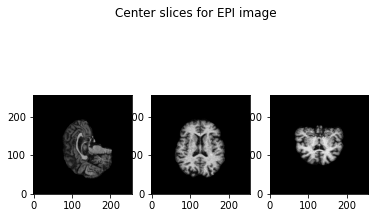

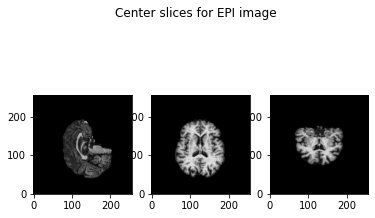

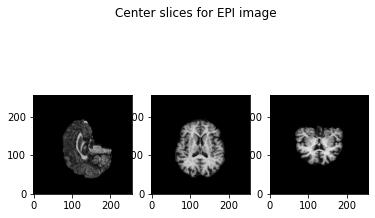

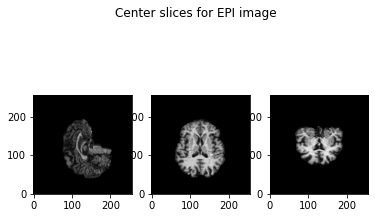

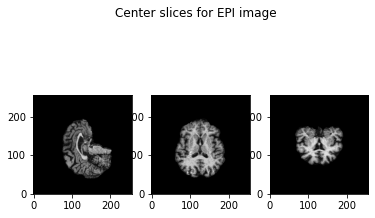

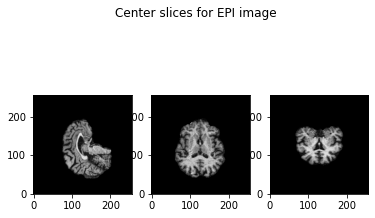

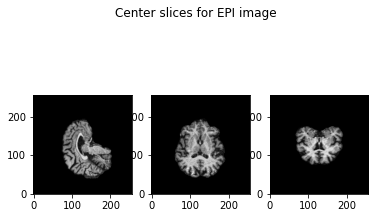

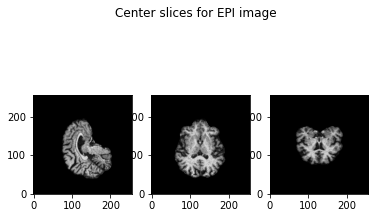

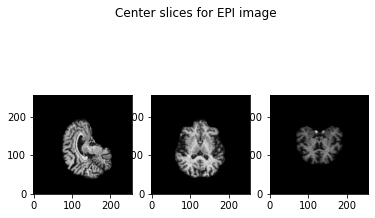

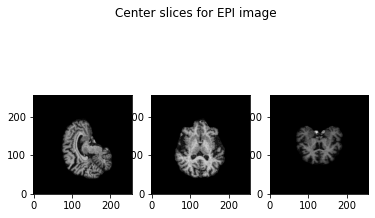

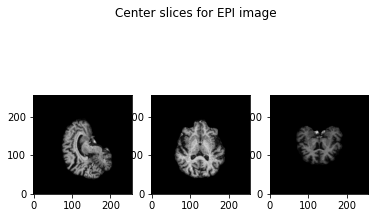

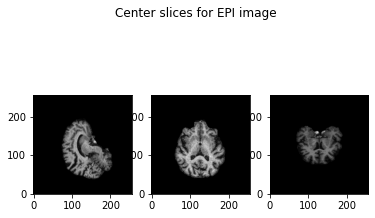

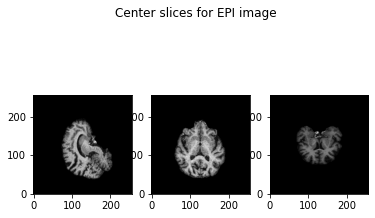

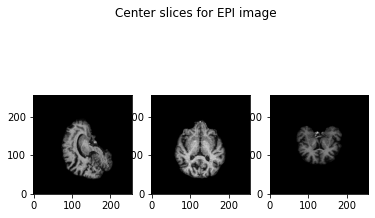

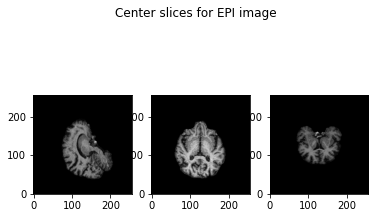

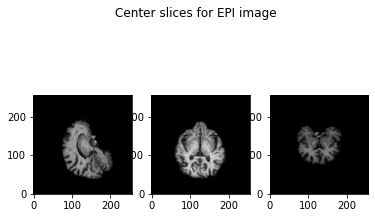

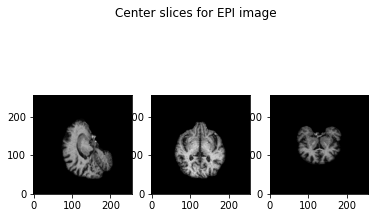

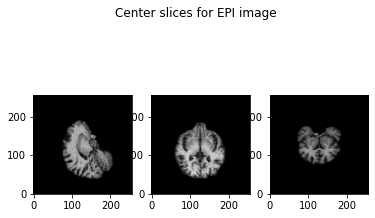

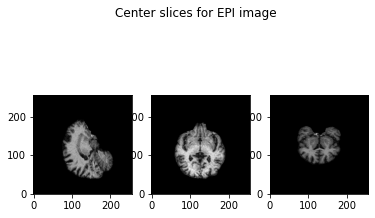

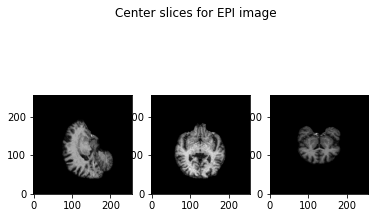

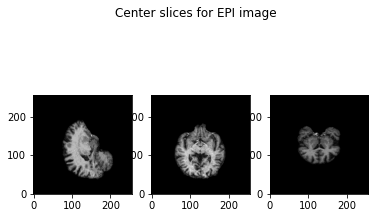

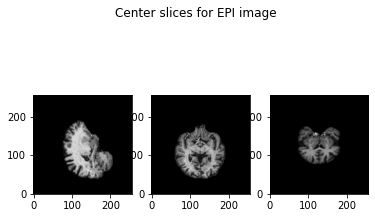

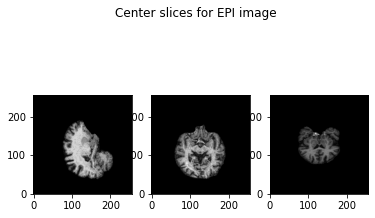

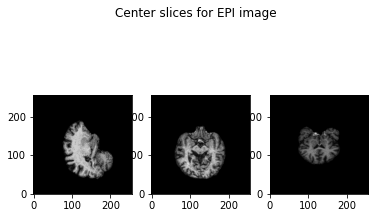

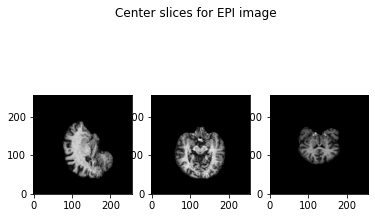

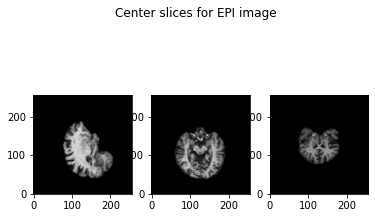

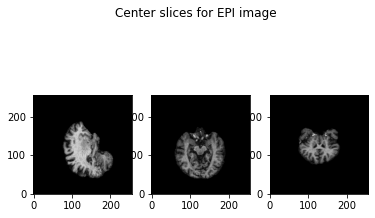

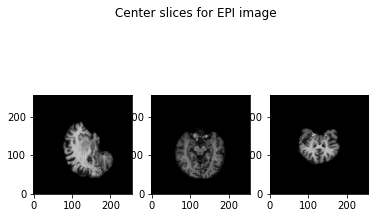

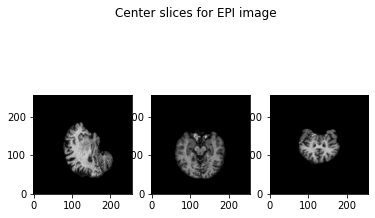

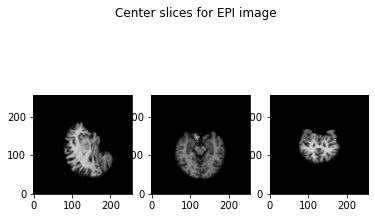

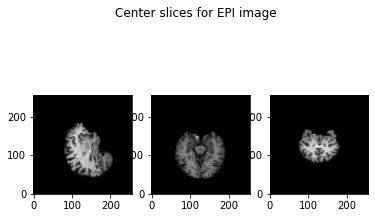

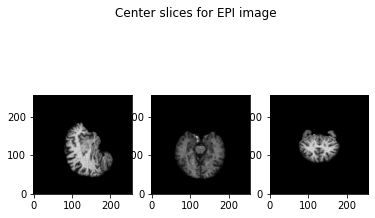

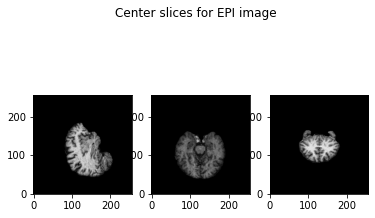

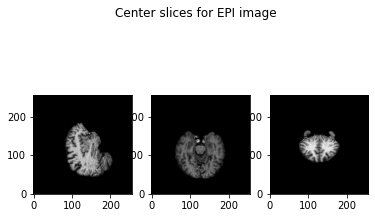

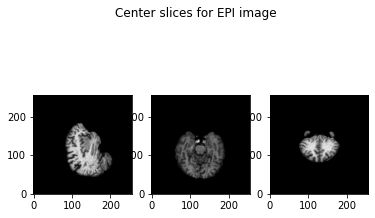

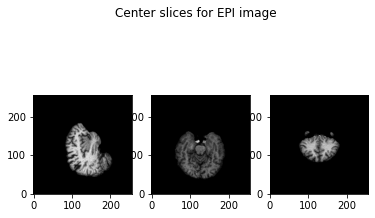

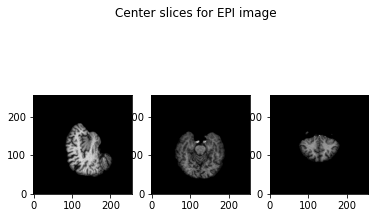

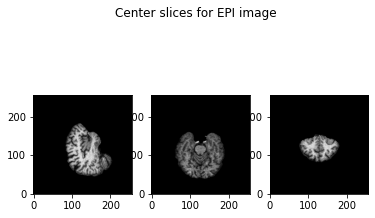

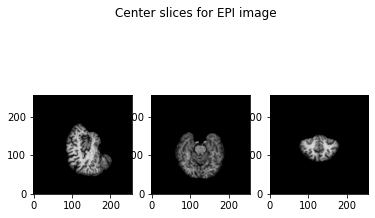

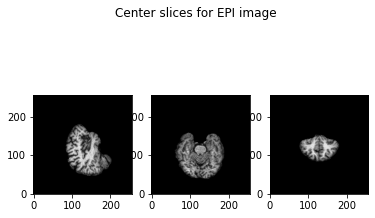

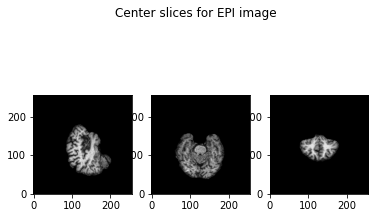

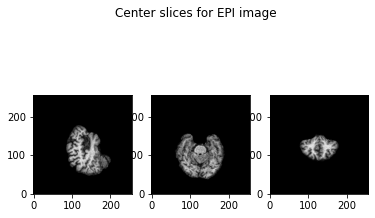

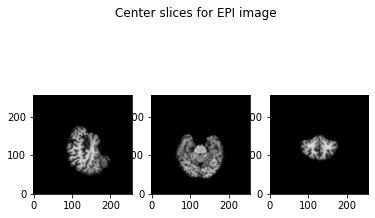

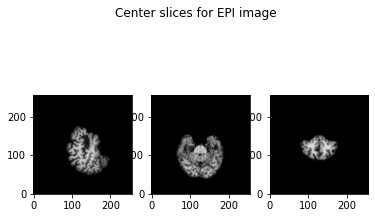

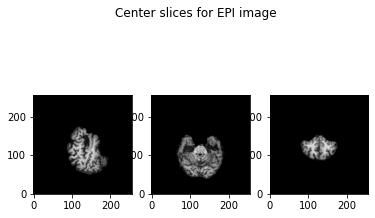

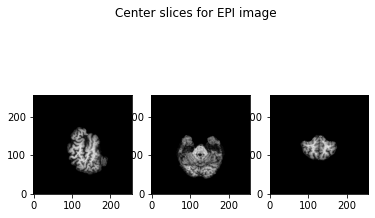

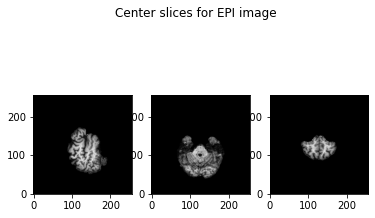

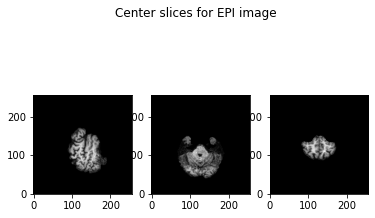

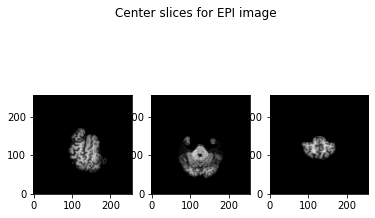

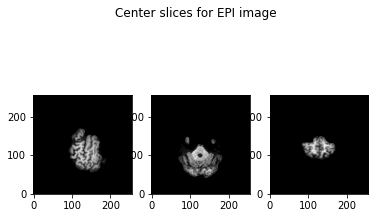

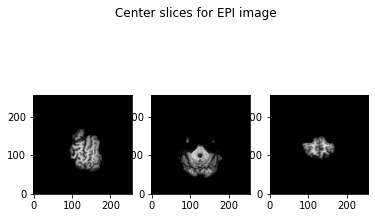

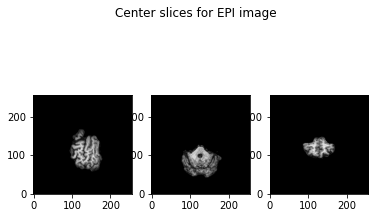

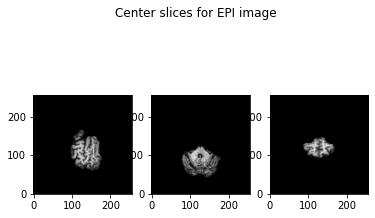

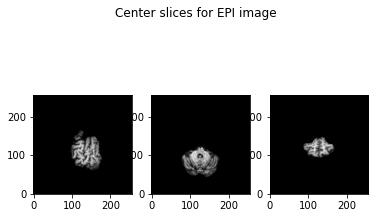

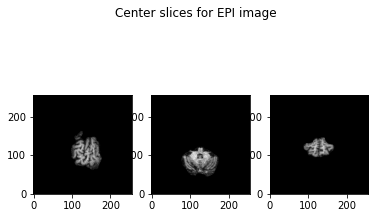

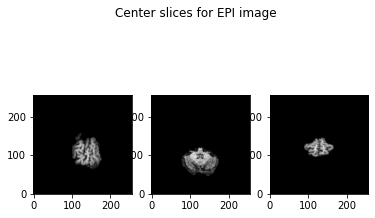

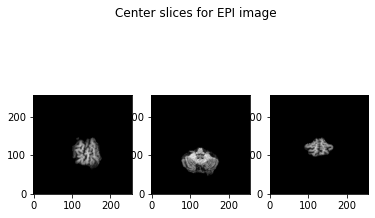

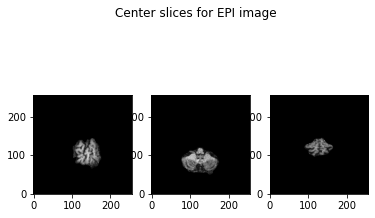

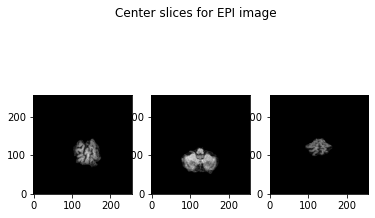

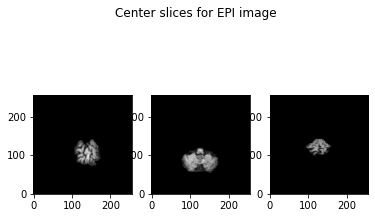

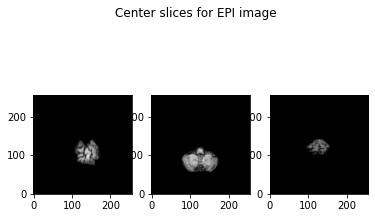

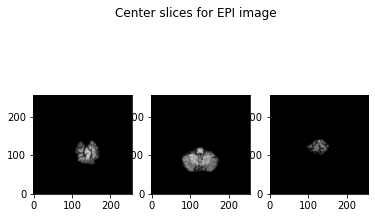

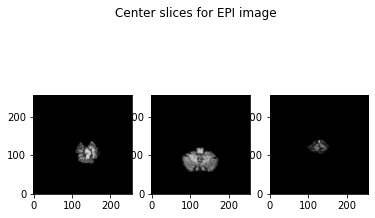

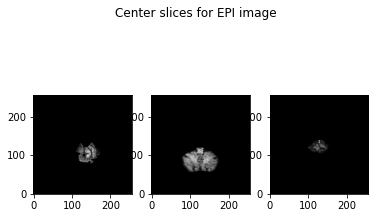

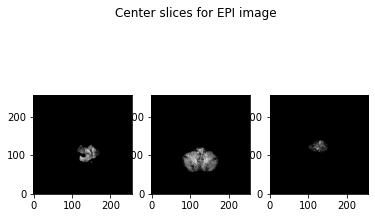

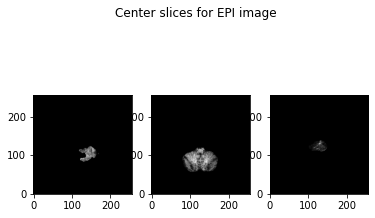

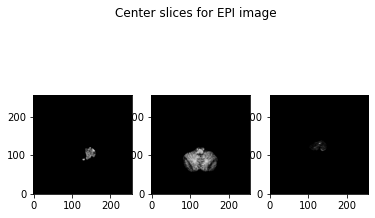

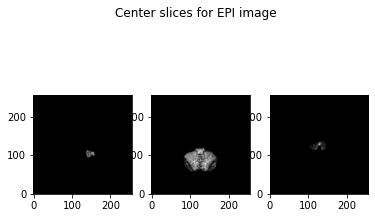

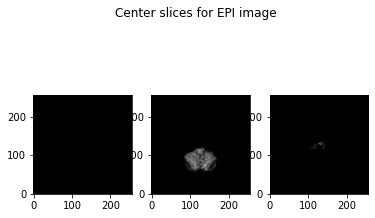

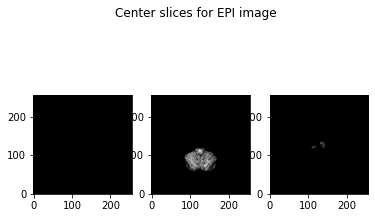

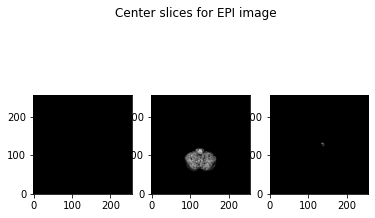

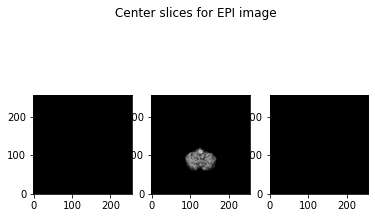

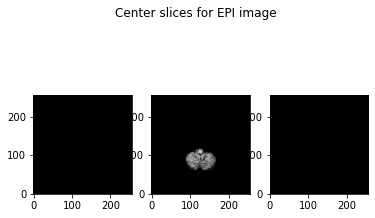

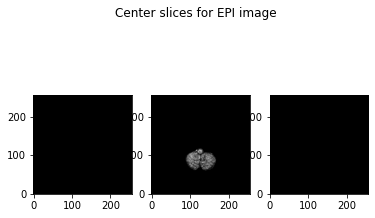

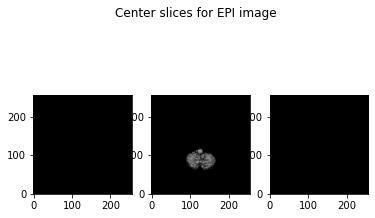

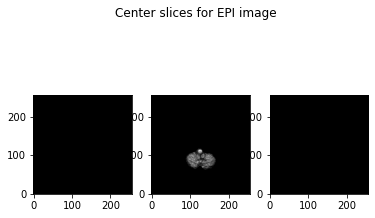

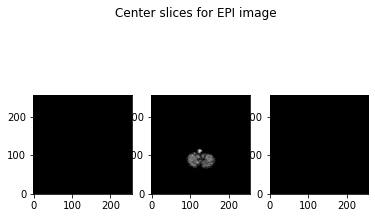

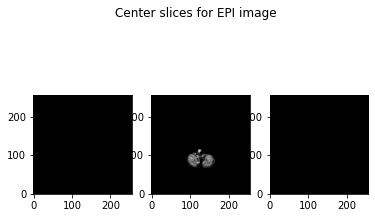

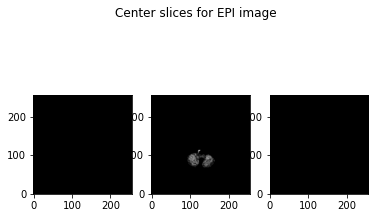

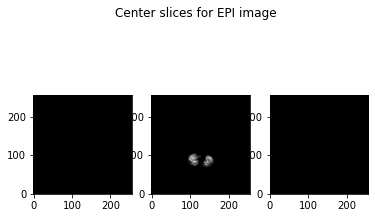

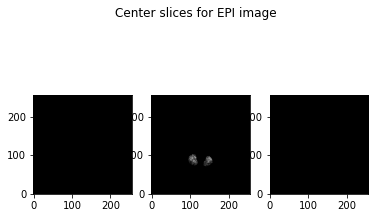

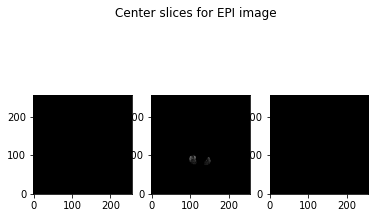

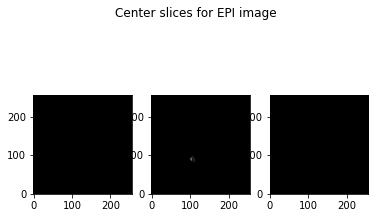

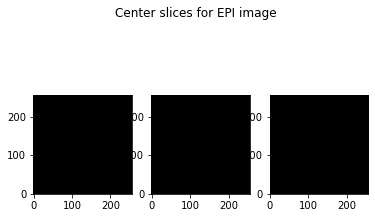

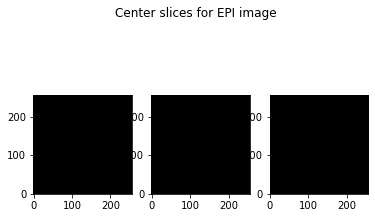

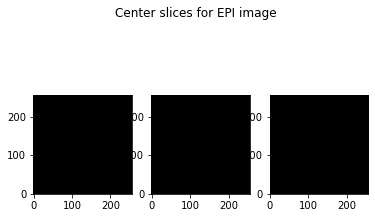

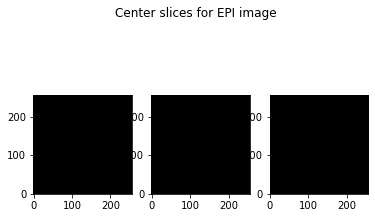

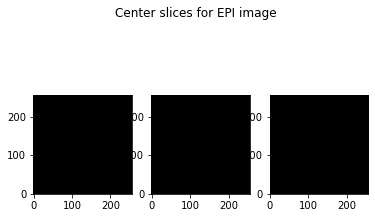

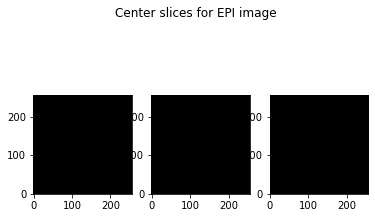

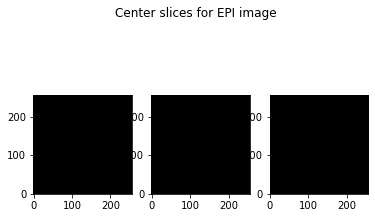

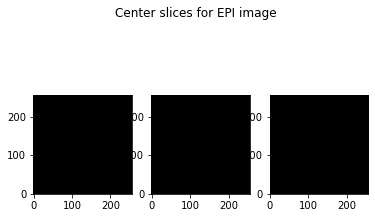

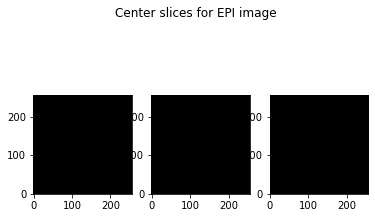

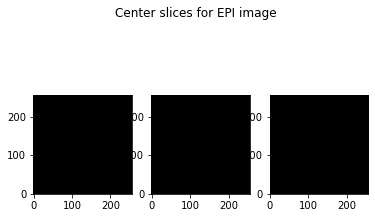

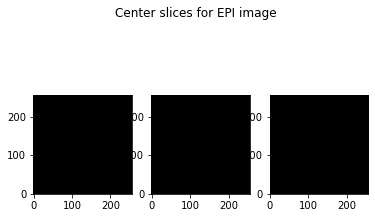

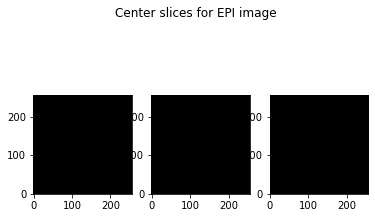

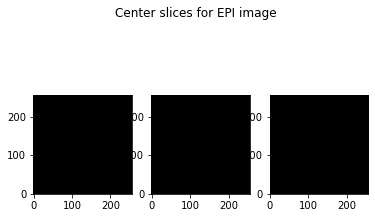

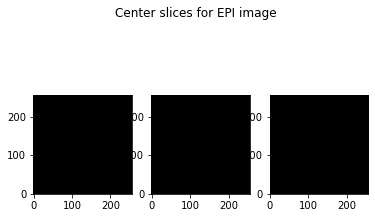

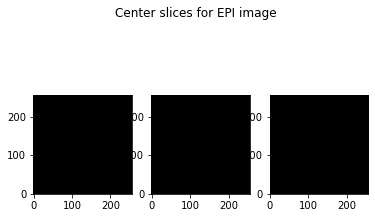

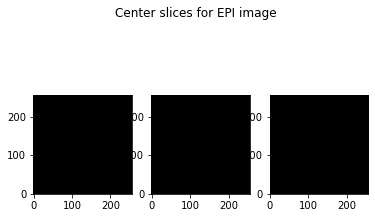

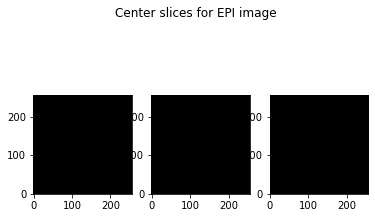

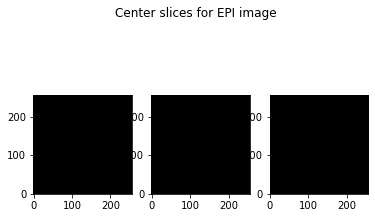

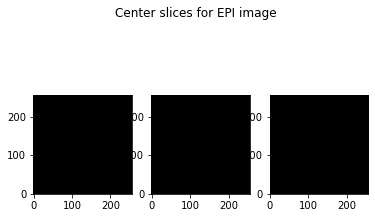

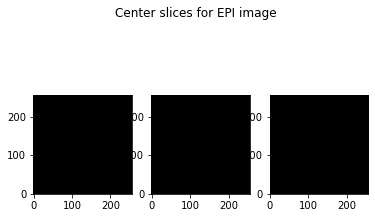

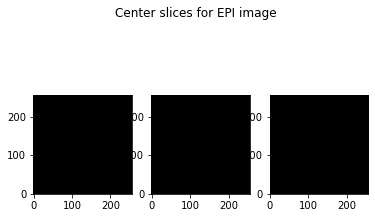

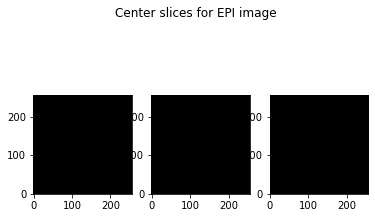

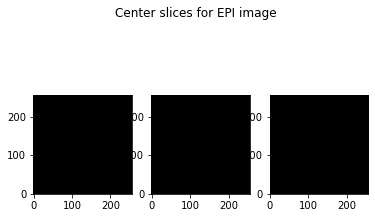

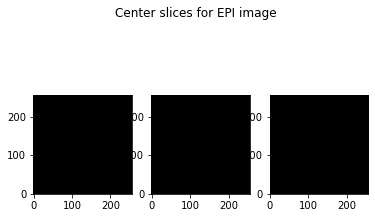

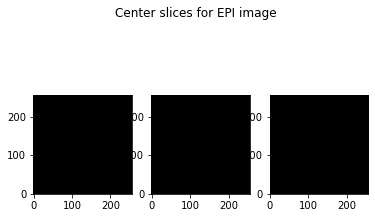

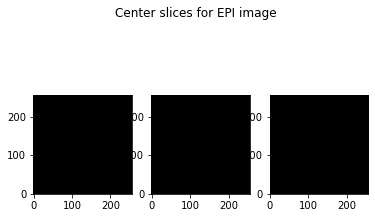

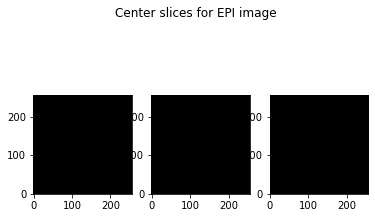

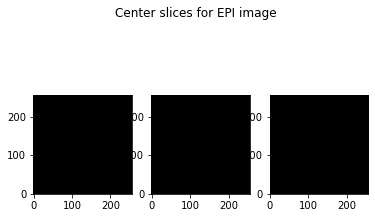

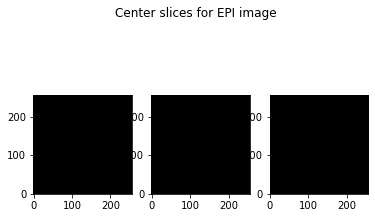

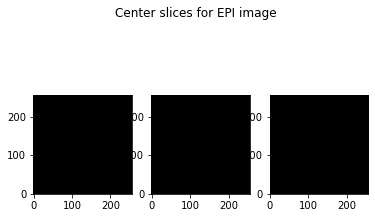

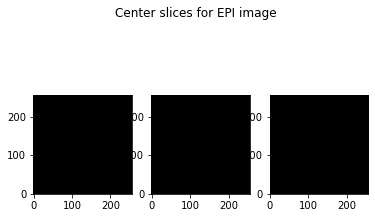

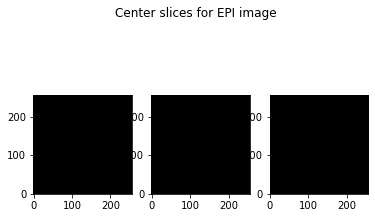

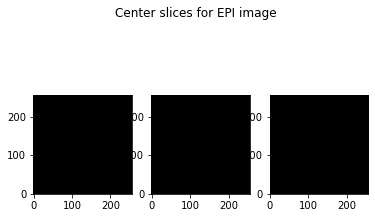

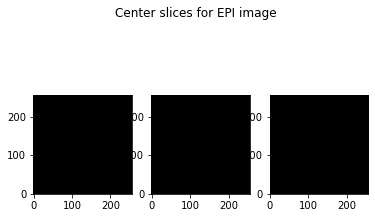

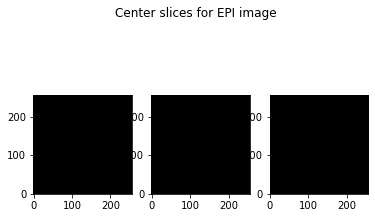

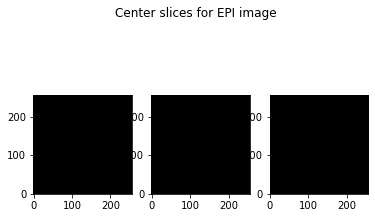

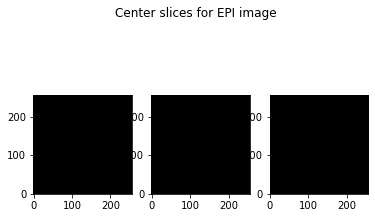

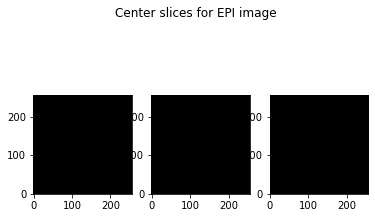

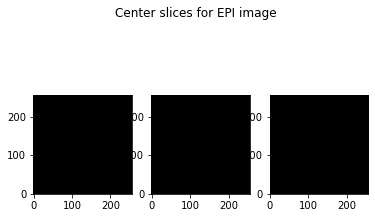

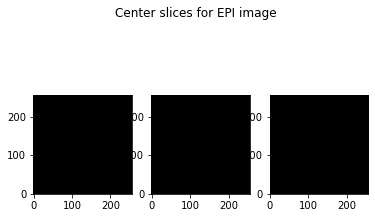

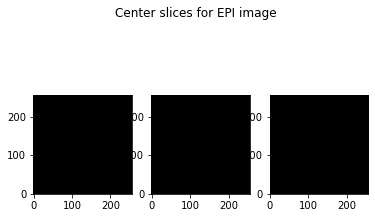

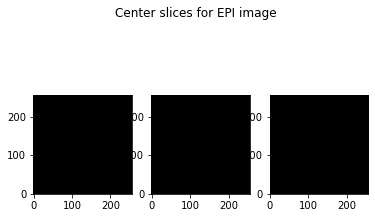

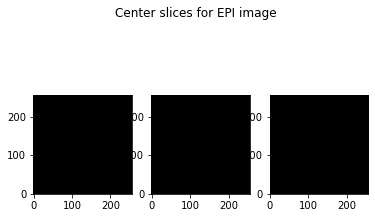

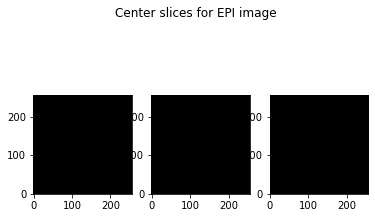

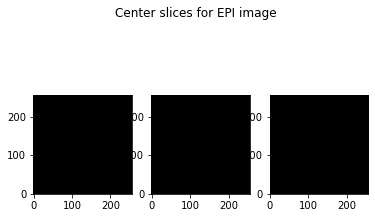

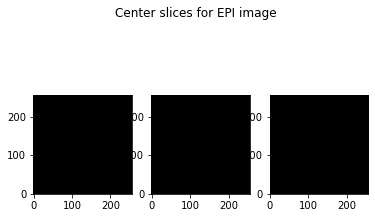

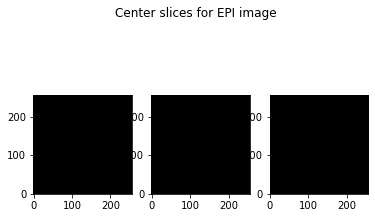

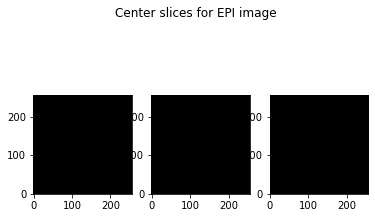

In [51]:
for i in range(0, 256):
    slice_0 = epi_img_data[i, :, :]
    slice_1 = epi_img_data[:, i, :]
    slice_2 = epi_img_data[:, :, i]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle("Center slices for EPI image")
    plt.show()
    plt.close()

Text(0.5, 0.98, 'Center slices for EPI image')

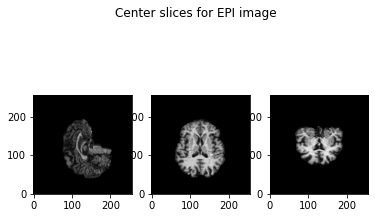

In [50]:
slice_0 = epi_img_data[128, :, :]
slice_1 = epi_img_data[:, 128, :]
slice_2 = epi_img_data[:, :, 128]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")  

In [30]:
from glob import glob

In [31]:
data_files = glob('../../brainmask_nii/*.nii')

In [33]:
data_files.sort()

In [34]:
import nibabel as nib

In [36]:
idx = 0

In [38]:
epi_img_data = nib.load(data_files[idx]).get_fdata()

In [52]:
epi_img_data.mean()

tensor(4.3217)

In [ ]:
# 01. Define Model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')
model = model_list[args.model](args.task_type).to(device)

In [ ]:
# 02. Setups
optimizer = optimizer_list[args.optimizer](model.parameters(),
                                           lr=args.learning_rate)
scheduler = scheduler_list[args.scheduler](optimizer, len(train_loader), eta_min=0) if args.scheduler else None
loss_fn = loss_list[args.loss_function]()
EPOCHS = range(args.epochs)

In [ ]:
# 03. Run
summary = SummaryWriter(f'./tensorboard/{datetime.now().strftime("%Y-%m-%d_%H%M")}') if args.save else None
fname = f'{datetime.now().strftime("%Y-%m-%d_%H%M-")}' if args.save else None
model, losses = run(model=model, epochs=EPOCHS, train_loader=train_loader, test_loader=test_loader,
                    optimizer=optimizer, loss_fn=loss_fn, device=device,
                    summary=summary, scheduler=scheduler, verbose=True)

if args.save:
    torch.save(model, f"./models/{fname}_model.pth")

In [ ]:
# 04. Evaluate
# 04-1. Loss Plot
#loss_plot(*losses, EPOCHS, args.loss_function)

# 04-2. Result Plot
train_true, train_pred = eval(model=model, loader=train_loader, device=device)
result_plot(task_type=args.task_type, trues=train_true, preds=train_pred, title='Train', fname=fname)

test_true, test_pred = eval(model=model, loader=test_loader, device=device)
result_plot(task_type=args.task_type, trues=test_true, preds=test_pred, title='Test', fname=fname)